In [76]:
import glob
import os

import numpy as np
import pandas as pd
import seaborn as sns

In [77]:
ANNOTATION_DIR = R"C:\Users\user\AppData\Roaming\Godot\app_userdata\GodotWebsocketServer\v3_gracia_annotation"

In [78]:
MOTION = "HIT"

In [79]:
file_pattern = os.path.join(ANNOTATION_DIR, "*.csv")
csv_files = glob.glob(file_pattern)
print(len(csv_files))
df = pd.concat(map(pd.read_csv, csv_files), ignore_index=True)

34


<Axes: xlabel='motion_type', ylabel='count'>

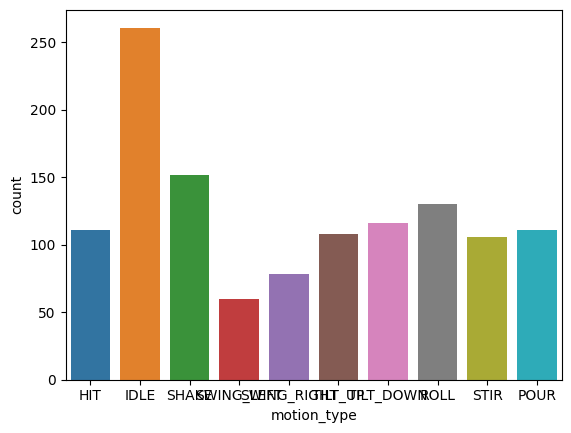

In [80]:
sns.countplot(df, x="motion_type", hue="motion_type")

In [81]:
len(df)

1233

In [82]:
df.drop(columns=df.filter(regex=r'^ahrs').columns, inplace=True)

In [83]:
# Keeps values equal to 'X', changes everything else to 'Y'
# df['motion_type'] = df['motion_type'].where(df['motion_type'] == f'{MOTION}', f'NOT_{MOTION}')

In [84]:
df.head()

,gyro_x_0,gyro_y_0,gyro_z_0,accel_x_0,accel_y_0,accel_z_0,mag_x_0,mag_y_0,mag_z_0,gyro_x_1,...,gyro_x_29,gyro_y_29,gyro_z_29,accel_x_29,accel_y_29,accel_z_29,mag_x_29,mag_y_29,mag_z_29,motion_type
0,0.160505,0.037339,0.145386,4.541800,-7.501333,4.220978,2.94,-74.220001,38.579998,0.278402,...,0.693790,-0.265650,0.991434,8.171710,3.203442,2.331953,18.000000,-57.419998,32.040001,HIT
1,1.044427,-0.136147,0.497855,-3.725378,-12.806884,3.701436,6.30,-70.559998,37.680000,1.073748,...,0.676075,0.725173,2.048842,8.418312,-0.299275,1.233014,17.940001,-64.320000,31.260000,HIT
2,0.207541,1.263957,3.775758,8.705617,1.094150,1.154005,17.16,-66.360001,32.759998,0.207541,...,-2.309223,-4.845307,-14.213001,-48.110584,-7.041646,-3.150769,8.460000,-65.939995,36.360001,IDLE
3,0.414014,0.720286,1.843591,5.245995,-6.196493,4.237737,6.42,-72.900002,38.399998,0.188605,...,-0.662331,2.532113,2.254704,3.213019,6.328175,5.564424,20.160000,-53.699997,29.519999,HIT
4,-11.418446,-2.649857,-19.710789,-12.996026,78.455597,37.173573,15.48,-59.579998,32.099998,-4.303088,...,0.355371,0.172951,1.211346,9.967360,3.754108,-0.371101,20.219999,-60.119999,30.599998,IDLE


<Axes: xlabel='motion_type', ylabel='count'>

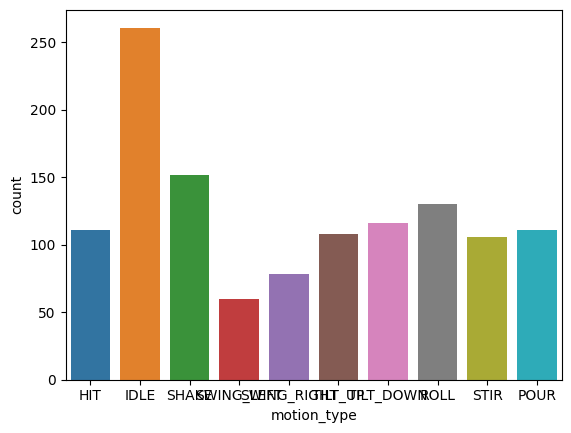

In [85]:
sns.countplot(df, x="motion_type", hue="motion_type")

In [ ]:
X_df = df.drop(columns=["motion_type"])
y = df["motion_type"].values

In [87]:
# n_timesteps = 30
# channels = ["gyro_x", "gyro_y", "gyro_z", "accel_x", "accel_y", "accel_z", "mag_x", "mag_y", "mag_z"]
# n_channels = len(channels)

# X = np.zeros((len(df), n_channels, n_timesteps))

# for t in range(n_timesteps):
#     for c, channel in enumerate(channels):
#         col_name = f"{channel}_{t}"
#         X[:, c, t] = X_df[col_name].values

In [88]:
X = X_df.values

In [89]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_enc = le.fit_transform(y)

In [90]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, random_state=42)

In [91]:
from sktime.transformations.panel.rocket import MiniRocketMultivariate
from sklearn.linear_model import RidgeClassifier
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sktime.classification.deep_learning import InceptionTimeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [92]:
clf_minirocket = SVC()

In [93]:
# clf_minirocket = make_pipeline(
#     MiniRocketMultivariate(random_state=42),
#     StandardScaler(with_mean=False),
#     RidgeClassifier(alpha=1.0)
# )

In [94]:
# clf_minirocket = KNeighborsTimeSeriesClassifier(n_neighbors=1)

In [95]:
clf_minirocket.fit(X_train, y_train)

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [96]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = clf_minirocket.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred, average="weighted"))
print(recall_score(y_test, y_pred, average="weighted"))
print(f1_score(y_test, y_pred, average="weighted"))

0.97165991902834
0.972125128875701
0.97165991902834
0.9716638703480809


In [97]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score

In [98]:
precision_macro = make_scorer(
    precision_score, average="macro", zero_division=0
)

recall_macro = make_scorer(
    recall_score, average="macro", zero_division=0
)

f1_macro = make_scorer(
    f1_score, average="macro", zero_division=0
)

In [99]:
scores_accuracy = cross_val_score(
    clf_minirocket, X_test, y_test, cv=5, scoring="accuracy"
)

scores_precision = cross_val_score(
    clf_minirocket, X_test, y_test, cv=5, scoring=precision_macro
)

scores_recall = cross_val_score(
    clf_minirocket, X_test, y_test, cv=5, scoring=recall_macro
)

scores_f1 = cross_val_score(
    clf_minirocket, X_test, y_test, cv=5, scoring=f1_macro
)

In [100]:
print("Cross-validated Accuracy :", scores_accuracy.mean(), "±", scores_accuracy.std())
print("Cross-validated Precision:", scores_precision.mean(), "±", scores_precision.std())
print("Cross-validated Recall   :", scores_recall.mean(), "±", scores_recall.std())
print("Cross-validated F1-score :", scores_f1.mean(), "±", scores_f1.std())

Cross-validated Accuracy : 0.890530612244898 ± 0.028151313642677766
Cross-validated Precision: 0.9349401709401709 ± 0.012323462191900189
Cross-validated Recall   : 0.9015959595959595 ± 0.021213314059774634
Cross-validated F1-score : 0.9050369153438206 ± 0.015872961353939417


In [101]:
from joblib import dump

In [102]:
dump(le, "label_encoder.joblib")

['label_encoder.joblib']

In [103]:
dump(clf_minirocket, "minirocket_hit_nohit.joblib")

['minirocket_hit_nohit.joblib']